# Lotka-Volterra system with a Runge-Kutta method

In this example we present how to write a program to solve the Lotka-Volterra equations with Ponio.

The system is definied as:

$$
  \begin{aligned}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x  - \beta xy \\
    \frac{\mathrm{d}y}{\mathrm{d}t} &= \delta xy - \gamma y \\
  \end{aligned}
$$

where:

* $x$ is the number of prey
* $y$ is the number of predators
* $t$ represents time
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are postive real parameters describing the interaction of the two species.

We would like to compute the invariant $V$ definied by:

$$
  V = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)
$$

## Define the state

In Ponio is build to solve a problem defined as:

$$
  \dot{u}(t) = f(t,u(t))
$$

we defined as a state (or `state_t`) the type which represents $u$. In scalar problems, `state_t` is often `double`. In system problems, `state_t` has multiple composants and Ponio need to make some arithmetic operations on it, so it can be a [`std::valarray<double>`](https://en.cppreference.com/w/cpp/numeric/valarray) or [Eigen vector](https://eigen.tuxfamily.org/index.php?title=Main_Page), etc.

For Lotka-Volterra we have 2 composants so we will use in this example `std::valarray<double>`. We can defined this as:

```cpp
  using state_t = std::valarray<double>;
```

## Define problem

The [`ode::solve`](#) function take as first argument a problem. In Ponio, a problem is a invokable object that take two arguments: $t$ the current time, and $u$ the current solution. So a problem can be:

* a simple function
* a lambda function
* a functor
* a [`ode::problem`](#) (which need an invokable object)

A problem represents function $f$ in $\dot{u}=f(t,u)$ ODE. We would like to change easly  parameter so we will use a functor (a class that overload `()` operator):

```cpp
#include <valarray>

class Lotka_Volterra
{
    using state_t = std::valarray<double>;

    double alpha;
    double beta;
    double gamma;
    double delta;

    public:

    Lotka_Volterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    state_t
    operator() (double tn, state_t const& un)
    {
        double x = un[0], y = un[1];
        double dx = alpha*x - beta*x*y;
        double dy = delta*x*y - gamma*y;
        return {dx,dy};
    }
};
```

## Simple example

If we would like to save all iterations into a file we can use a `observer::file_observer`, if we would like to display all into `std::cout` we can use `observer::cout_observer`. In this example we print all into a file.

```cpp
int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    auto pb  = Lotka_Volterra(alpha,beta,gamma,delta);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ode::solve(pb, ode::butcher::rk_44<>(), u_ini, {0.,tf}, dt, "lv1.dat"_fobs);

    return 0;
}
```

Where `ode::butcher::rk_44<>()` create an instance of algorithm to solve the problem, which represent classical RK(4,4) method.

In [1]:
%system mkdir -p lv_demo

[]

In [2]:
%%writefile lv_demo/lv1.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/butcher_methods.hpp"

class Lotka_Volterra
{
    using state_t = std::valarray<double>;

    double alpha;
    double beta;
    double gamma;
    double delta;

    public:

    Lotka_Volterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    state_t
    operator() (double tn, state_t const& un)
    {
        double x = un[0], y = un[1];
        double dx = alpha*x - beta*x*y;
        double dy = delta*x*y - gamma*y;
        return {dx,dy};
    }
};

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    auto pb  = Lotka_Volterra(alpha,beta,gamma,delta);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ode::solve(pb, ode::butcher::rk_44(), u_ini, {0.,tf}, dt, "lv_demo/lv1.dat"_fobs);

    return 0;
}

Writing lv_demo/lv1.cpp


In [3]:
%system $CXX -std=c++20 -I ../include lv_demo/lv1.cpp -o lv_demo/lv1 && ./lv_demo/lv1

[]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = np.loadtxt("lv_demo/lv1.dat")
t = data[:,0]
x = data[:,1]
y = data[:,2]

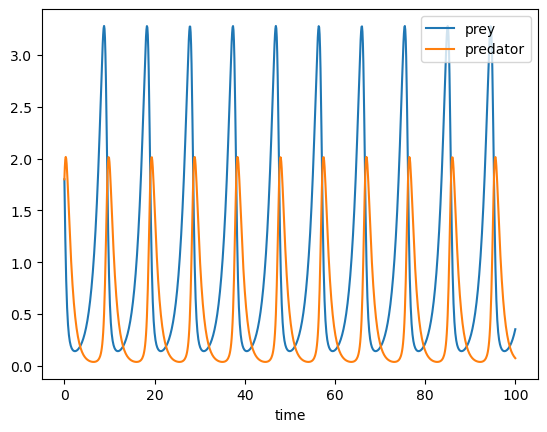

In [6]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.xlabel("time")
plt.legend()
plt.show()

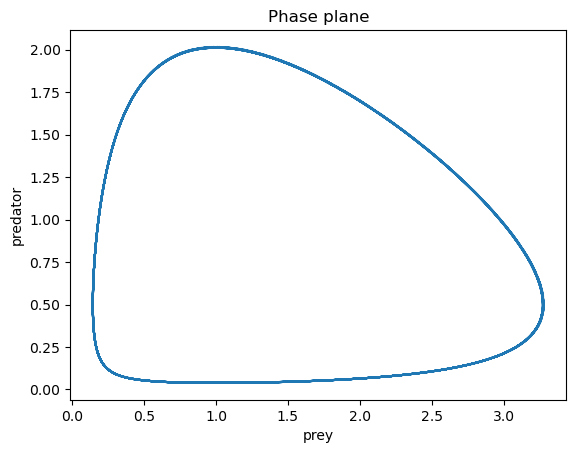

In [7]:
plt.plot(x,y)
plt.xlabel("prey")
plt.ylabel("predator")
plt.title("Phase plane")
plt.show()

Now define the invariant $V$ :
    
$$
  V = \delta x - \ln(x) + \beta y - \alpha \ln(y)
$$

In [8]:
def V(x,y, alpha=2./3., beta=4./3., gamma=1., delta=1.):
    return delta*x - np.log(x) + beta*y - alpha*np.log(y)

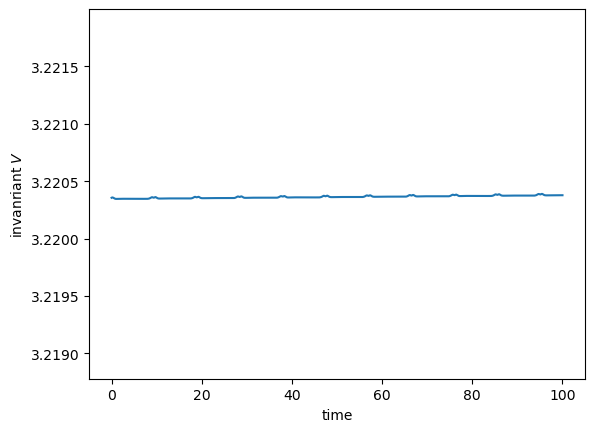

In [9]:
plt.plot(t,V(x,y))
plt.xlabel("time")
plt.ylabel("invanriant $V$")
vmax = max(V(x,y))
plt.ylim([(1-5e-4)*vmax,(1+5e-4)*vmax])
plt.show()